# Convolutional Neural Networks - Building CNN Classifiers


The most popular deep learning models leveraged for computer vision problems are convolutional neural networks (CNNs)!

![](https://miro.medium.com/max/2000/1*rO65zGl2k7xVBRhJZggQSA.gif)

We will look at how we can build, train and evaluate a multi-class CNN classifier in this notebook.

<div style="text-align: right"><i><font size="2">Tutorial by: <a href="https://www.linkedin.com/in/dipanzan" target="_parent">Dipanjan (DJ) Sarkar</a></font></i></div>


# Load Dependencies 

This leverages the __`tf.keras`__ API style and hence it is recommended you try this out on TensorFlow 2.x

In [1]:
# to prevent unnecessary warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# TensorFlow and tf.keras
import tensorflow as tf

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt
import os
import subprocess
import cv2
import json
import requests
from tqdm import tqdm

print(tf.__version__)

2.3.0


# Main Objective — Building & Deploying an Apparel Classifier

We will keep things simple here with regard to the key objective. We will build a simple apparel classifier by training models on the very famous [Fashion MNIST](https://github.com/zalandoresearch/fashion-mnist) dataset based on Zalando’s article images — consisting of a training set of 60,000 examples and a test set of 10,000 examples. Each example is a 28x28 grayscale image, associated with a label from 10 classes. The idea is to classify these images into an apparel category amongst 10 categories on which we will be training our models on.

Here's an example how the data looks (each class takes three-rows):

<table>
  <tr><td>
    <img src="https://raw.githubusercontent.com/zalandoresearch/fashion-mnist/master/doc/img/fashion-mnist-sprite.png"
         alt="Fashion MNIST sprite"  width="600">
  </td></tr>
  <tr><td align="center">
    <a href="https://github.com/zalandoresearch/fashion-mnist">Fashion-MNIST samples</a> (by Zalando, MIT License).<br/>&nbsp;
  </td></tr>
</table>

Fashion MNIST is intended as a drop-in replacement for the classic [MNIST](http://yann.lecun.com/exdb/mnist/) dataset—often used as the "Hello, World" of machine learning programs for computer vision. You can access the Fashion MNIST directly from TensorFlow.

__Note:__ Although these are really images, they are loaded as NumPy arrays and not binary image objects.

We will build the following two deep learning CNN (Convolutional Neural Network) classifiers in this notebook.
- A simple CNN trained from scratch
- Fine-tuning a pre-trained VGG-19 CNN

The idea is to look at how to build your own CNN from scratch and also to briefly look at transfer learning where you fine-tune a pre-trained model to adapt it to classify images based on your dataset.

# Load Dataset
Here we will leverage an out of the box dataset to keep things simple as we mentioned earlier by leveraging the Fashion-MNIST dataset.

In [2]:
fashion_mnist = tf.keras.datasets.fashion_mnist
(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

print('\nTrain_images.shape: {}, of {}'.format(train_images.shape, train_images.dtype))
print('Test_images.shape: {}, of {}'.format(test_images.shape, test_images.dtype))


Train_images.shape: (60000, 28, 28), of uint8
Test_images.shape: (10000, 28, 28), of uint8


# Brief on CNNs

CNNs typically consist of multiple convolution and pooling layers which help the deep learning model in automatically extracting relevant features from visual data like images. Due to this multi-layered architecture, CNNs learn a robust hierarchy of features, which are spatial, rotation, and translation invariant.

![](https://miro.medium.com/max/1456/1*NKL76WYQwH5LuqyaQTjBNw.png)

The key operations in a CNN model are depicted in the figure above. Any image can be represented as a tensor of pixel values. The convolution layers help in extracting features from this image (forms feature maps). Shallower layers (closer to the input data) in the network learn very generic features like edges, corners and so on. Deeper layers in the network (closer to the output layer) learn very specific features pertaining to the input image. The following graphic helps summarize the key aspects of any CNN model.

![](https://miro.medium.com/max/1366/1*nCQeDMjKoTGst1RiCDo9Fw.png)

We will be building a CNN from scratch as well as leverage the power of transfer learning, where we use pre-trained deep learning CNNs in this tutorial. 

# 1. Training a simple CNN Classifier from Scratch

In this section, we will train a basic 2-layer CNN model from scratch.

## Reshaping Image Data for Modeling

We do need to reshape our data before we train our model. Here we will work on grayscale, 1-channel images (image pixel tensors)

In [3]:
# reshape for feeding into the model
train_images_gr = train_images.reshape(train_images.shape[0], 28, 28, 1)
test_images_gr = test_images.reshape(test_images.shape[0], 28, 28, 1)

print('\nTrain_images.shape: {}, of {}'.format(train_images_gr.shape, train_images_gr.dtype))
print('Test_images.shape: {}, of {}'.format(test_images_gr.shape, test_images_gr.dtype))


Train_images.shape: (60000, 28, 28, 1), of uint8
Test_images.shape: (10000, 28, 28, 1), of uint8


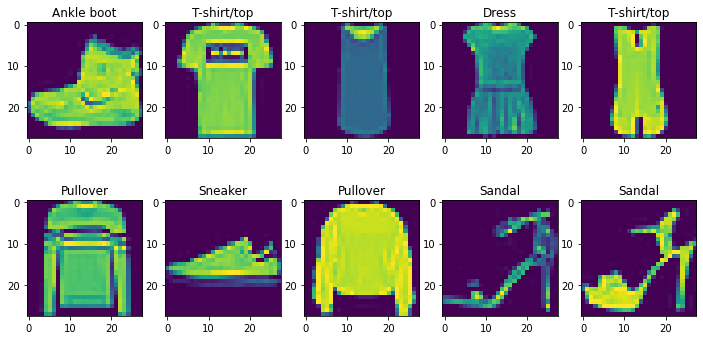

In [4]:
fig, ax = plt.subplots(2, 5, figsize=(12, 6))
c = 0
for i in range(10):
    idx = i // 5
    idy = i % 5 
    ax[idx, idy].imshow(train_images_gr[i].reshape(28,28))
    ax[idx, idy].set_title(class_names[train_labels[i]])

## Build CNN Model Architecture

We will now build our basic 2-layer CNN model architecture.

In [5]:
# define input shape
INPUT_SHAPE = (28, 28, 1)

# define sequential model
model = tf.keras.models.Sequential()
# define conv-pool layers - set 1
model.add(tf.keras.layers.Conv2D(filters=16, kernel_size=(3, 3), strides=(1, 1), 
                                activation='relu', padding='valid', input_shape=INPUT_SHAPE))
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
# define conv-pool layers - set 2
model.add(tf.keras.layers.Conv2D(filters=32, kernel_size=(3, 3), strides=(1, 1), 
                                activation='relu', padding='valid', input_shape=INPUT_SHAPE))
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))

# add flatten layer
model.add(tf.keras.layers.Flatten())

# add dense layers with some dropout
model.add(tf.keras.layers.Dense(256, activation='relu'))
model.add(tf.keras.layers.Dropout(rate=0.3))
model.add(tf.keras.layers.Dense(256, activation='relu'))
model.add(tf.keras.layers.Dropout(rate=0.3))

# add output layer
model.add(tf.keras.layers.Dense(10, activation='softmax'))

# compile model
model.compile(optimizer='adam', 
              loss='sparse_categorical_crossentropy', 
              metrics=['accuracy'])

# view model layers
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 26, 26, 16)        160       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 13, 13, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 11, 11, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 5, 5, 32)          0         
_________________________________________________________________
flatten (Flatten)            (None, 800)               0         
_________________________________________________________________
dense (Dense)                (None, 256)               205056    
_________________________________________________________________
dropout (Dropout)            (None, 256)               0

## Model Training

Let’s train our model for 100 epochs and look at the performance. We do apply an early-stopping to stop the model training immediately once we don't see an improvement in validation-loss over the last 2 epochs using the `EarlyStopping` callback.

In [6]:
EPOCHS = 100
train_images_scaled = train_images_gr / 255.
es_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=2, 
                                               restore_best_weights=True,
                                               verbose=1)

history = model.fit(train_images_scaled, train_labels,
                    batch_size=32,
                    callbacks=[es_callback], 
                    validation_split=0.1, epochs=EPOCHS,
                    verbose=1)

Epoch 1/100
1688/1688 [==============================] - 6s 3ms/step - loss: 0.5335 - accuracy: 0.8004 - val_loss: 0.3600 - val_accuracy: 0.8622
Epoch 2/100
1688/1688 [==============================] - 5s 3ms/step - loss: 0.3463 - accuracy: 0.8735 - val_loss: 0.2994 - val_accuracy: 0.8905
Epoch 3/100
1688/1688 [==============================] - 5s 3ms/step - loss: 0.2994 - accuracy: 0.8904 - val_loss: 0.2721 - val_accuracy: 0.8985
Epoch 4/100
1688/1688 [==============================] - 5s 3ms/step - loss: 0.2683 - accuracy: 0.9008 - val_loss: 0.2641 - val_accuracy: 0.9050
Epoch 5/100
1688/1688 [==============================] - 5s 3ms/step - loss: 0.2484 - accuracy: 0.9081 - val_loss: 0.2523 - val_accuracy: 0.9078
Epoch 6/100
1688/1688 [==============================] - 5s 3ms/step - loss: 0.2298 - accuracy: 0.9149 - val_loss: 0.2477 - val_accuracy: 0.9123
Epoch 7/100
1688/1688 [==============================] - 5s 3ms/step - loss: 0.2113 - accuracy: 0.9207 - val_loss: 0.2619 - val_ac

## Plot Learning Curves

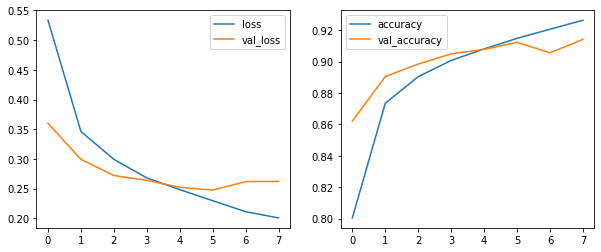

In [110]:
import pandas as pd

fig, ax = plt.subplots(1, 2, figsize=(10, 4))

history_df = pd.DataFrame(history.history)
history_df[['loss', 'val_loss']].plot(kind='line', ax=ax[0])
history_df[['accuracy', 'val_accuracy']].plot(kind='line', ax=ax[1]);

## Evaluate Model Performance on Test Data

In [8]:
test_images_scaled = test_images_gr / 255.
predictions = model.predict(test_images_scaled)
predictions[:5]

array([[2.96228220e-09, 1.40729128e-09, 3.28166272e-09, 4.85382123e-10,
        3.20554971e-10, 1.31543666e-05, 6.75393474e-09, 2.84109938e-05,
        4.73899808e-09, 9.99958396e-01],
       [9.57808766e-08, 1.73682932e-12, 9.99968171e-01, 1.73318848e-09,
        2.02346037e-05, 5.91135824e-14, 1.14859040e-05, 3.82084577e-15,
        1.43269244e-10, 2.11130450e-14],
       [7.13950451e-14, 1.00000000e+00, 1.13288734e-18, 3.04978590e-13,
        7.09287772e-15, 6.14905968e-23, 3.14292388e-14, 1.75216031e-20,
        2.42028604e-20, 7.32643976e-22],
       [1.16188266e-11, 1.00000000e+00, 1.48278877e-15, 3.84621085e-10,
        1.54540367e-12, 5.56595669e-19, 1.00561772e-11, 8.11787857e-18,
        1.61306638e-17, 1.33791108e-18],
       [3.43898460e-02, 2.39716082e-05, 1.21074151e-02, 2.02051480e-03,
        1.47844879e-02, 1.22156882e-06, 9.36640739e-01, 1.62844697e-06,
        2.63113707e-05, 3.75496802e-06]], dtype=float32)

In [9]:
prediction_labels = np.argmax(predictions, axis=1)
prediction_labels[:5]

array([9, 2, 1, 1, 6])

In [10]:
from sklearn.metrics import confusion_matrix, classification_report
import pandas as pd

print(classification_report(test_labels, prediction_labels, target_names=class_names))
pd.DataFrame(confusion_matrix(test_labels, prediction_labels), index=class_names, columns=class_names)

              precision    recall  f1-score   support

 T-shirt/top       0.87      0.83      0.85      1000
     Trouser       0.99      0.98      0.98      1000
    Pullover       0.84      0.87      0.85      1000
       Dress       0.91      0.91      0.91      1000
        Coat       0.87      0.82      0.85      1000
      Sandal       0.98      0.98      0.98      1000
       Shirt       0.70      0.76      0.73      1000
     Sneaker       0.97      0.94      0.95      1000
         Bag       0.99      0.98      0.98      1000
  Ankle boot       0.95      0.98      0.96      1000

    accuracy                           0.90     10000
   macro avg       0.91      0.90      0.91     10000
weighted avg       0.91      0.90      0.91     10000



,T-shirt/top,Trouser,Pullover,Dress,Coat,Sandal,Shirt,Sneaker,Bag,Ankle boot
T-shirt/top,829,0,17,15,2,1,131,0,5,0
Trouser,1,976,0,15,0,0,6,0,2,0
Pullover,12,0,869,6,37,0,76,0,0,0
Dress,12,4,14,914,20,0,35,0,1,0
Coat,0,2,72,29,818,0,78,0,1,0
Sandal,0,0,0,0,0,984,0,9,0,7
Shirt,94,2,64,22,56,0,758,0,4,0
Sneaker,0,0,0,0,0,10,0,942,0,48
Bag,3,1,4,3,3,2,2,5,977,0
Ankle boot,0,0,0,0,0,4,1,18,0,977


In [11]:
print(test_labels[:100])

[9 2 1 1 6 1 4 6 5 7 4 5 7 3 4 1 2 4 8 0 2 5 7 9 1 4 6 0 9 3 8 8 3 3 8 0 7
 5 7 9 6 1 3 7 6 7 2 1 2 2 4 4 5 8 2 2 8 4 8 0 7 7 8 5 1 1 2 3 9 8 7 0 2 6
 2 3 1 2 8 4 1 8 5 9 5 0 3 2 0 6 5 3 6 7 1 8 0 1 4 2]


In [ ]:
test_labels

In [50]:
test_image_idxs = [0, 23, 28]
test_labels[test_image_idxs]

array([9, 9, 9], dtype=uint8)

In [90]:
layer_outputs = [layer.output for layer in model.layers]
activation_model = tf.keras.models.Model(inputs=model.input, outputs=layer_outputs)

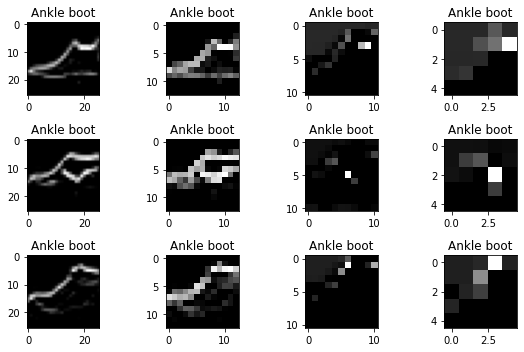

In [101]:
f, axarr = plt.subplots(3,4, figsize=(8, 5))

FIRST_IMAGE=0
SECOND_IMAGE=23
THIRD_IMAGE=28
CONVOLUTION_NUMBER = 13

for x in range(0,4):
  f1 = activation_model.predict(test_images_scaled[FIRST_IMAGE].reshape(1, 28, 28, 1))[x]
  axarr[0,x].imshow(f1[0, : , :, CONVOLUTION_NUMBER], cmap='binary_r')
  axarr[0,x].grid(False)
  axarr[0,x].set_title(class_names[test_labels[FIRST_IMAGE]])
  f2 = activation_model.predict(test_images_scaled[SECOND_IMAGE].reshape(1, 28, 28, 1))[x]
  axarr[1,x].imshow(f2[0, : , :, CONVOLUTION_NUMBER], cmap='binary_r')
  axarr[1,x].grid(False)
  axarr[1,x].set_title(class_names[test_labels[SECOND_IMAGE]])
  f3 = activation_model.predict(test_images_scaled[THIRD_IMAGE].reshape(1, 28, 28, 1))[x]
  axarr[2,x].imshow(f3[0, : , :, CONVOLUTION_NUMBER], cmap='binary_r')
  axarr[2,x].grid(False)
  axarr[2,x].set_title(class_names[test_labels[THIRD_IMAGE]])
plt.tight_layout()

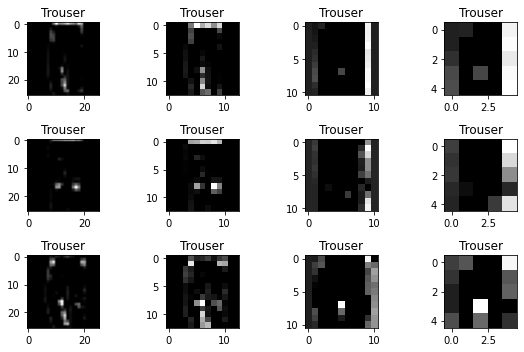

In [102]:
f, axarr = plt.subplots(3,4, figsize=(8, 5))

FIRST_IMAGE=2
SECOND_IMAGE=3
THIRD_IMAGE=5
CONVOLUTION_NUMBER = 13

for x in range(0,4):
  f1 = activation_model.predict(test_images_scaled[FIRST_IMAGE].reshape(1, 28, 28, 1))[x]
  axarr[0,x].imshow(f1[0, : , :, CONVOLUTION_NUMBER], cmap='binary_r')
  axarr[0,x].grid(False)
  axarr[0,x].set_title(class_names[test_labels[FIRST_IMAGE]])
  f2 = activation_model.predict(test_images_scaled[SECOND_IMAGE].reshape(1, 28, 28, 1))[x]
  axarr[1,x].imshow(f2[0, : , :, CONVOLUTION_NUMBER], cmap='binary_r')
  axarr[1,x].grid(False)
  axarr[1,x].set_title(class_names[test_labels[SECOND_IMAGE]])
  f3 = activation_model.predict(test_images_scaled[THIRD_IMAGE].reshape(1, 28, 28, 1))[x]
  axarr[2,x].imshow(f3[0, : , :, CONVOLUTION_NUMBER], cmap='binary_r')
  axarr[2,x].grid(False)
  axarr[2,x].set_title(class_names[test_labels[THIRD_IMAGE]])
plt.tight_layout()

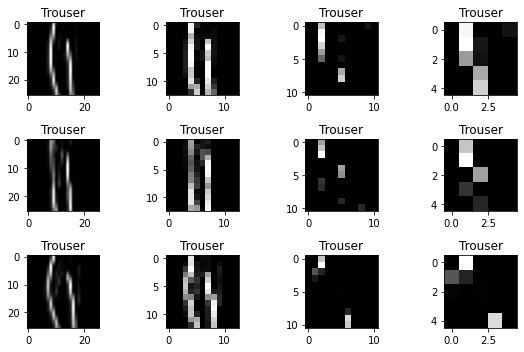

In [103]:
f, axarr = plt.subplots(3,4, figsize=(8, 5))

FIRST_IMAGE=2
SECOND_IMAGE=3
THIRD_IMAGE=5
CONVOLUTION_NUMBER = 3

for x in range(0,4):
  f1 = activation_model.predict(test_images_scaled[FIRST_IMAGE].reshape(1, 28, 28, 1))[x]
  axarr[0,x].imshow(f1[0, : , :, CONVOLUTION_NUMBER], cmap='binary_r')
  axarr[0,x].grid(False)
  axarr[0,x].set_title(class_names[test_labels[FIRST_IMAGE]])
  f2 = activation_model.predict(test_images_scaled[SECOND_IMAGE].reshape(1, 28, 28, 1))[x]
  axarr[1,x].imshow(f2[0, : , :, CONVOLUTION_NUMBER], cmap='binary_r')
  axarr[1,x].grid(False)
  axarr[1,x].set_title(class_names[test_labels[SECOND_IMAGE]])
  f3 = activation_model.predict(test_images_scaled[THIRD_IMAGE].reshape(1, 28, 28, 1))[x]
  axarr[2,x].imshow(f3[0, : , :, CONVOLUTION_NUMBER], cmap='binary_r')
  axarr[2,x].grid(False)
  axarr[2,x].set_title(class_names[test_labels[THIRD_IMAGE]])
plt.tight_layout()

# 2. Fine-tuning a pre-trained VGG-19 CNN Model

Here, we will use a VGG-19 model which was pre-trained on the ImageNet dataset by fine-tuning it on the Fashion-MNIST dataset. 

## Transfer Learning

![](https://i.imgur.com/WcUabml.png)

## Model Architecture Details

![](https://i.imgur.com/1VZ7MlO.png)

## Reshaping Image Data for Modeling

We do need to reshape our data before we train our model. Here we will convert the images to 3-channel images (image pixel tensors) as the VGG model was originally trained on RGB images

In [111]:
train_images_3ch = np.stack([train_images]*3, axis=-1)
test_images_3ch = np.stack([test_images]*3, axis=-1)

print('\nTrain_images.shape: {}, of {}'.format(train_images_3ch.shape, train_images_3ch.dtype))
print('Test_images.shape: {}, of {}'.format(test_images_3ch.shape, test_images_3ch.dtype))


Train_images.shape: (60000, 28, 28, 3), of uint8
Test_images.shape: (10000, 28, 28, 3), of uint8


## Resizing Image Data for Modeling

The minimum image size expected by the VGG model is 32x32 so we need to resize our images

In [112]:
import cv2

def resize_image_array(img, img_size_dims):
    img = cv2.resize(img, dsize=img_size_dims, 
                     interpolation=cv2.INTER_CUBIC)
    img = np.array(img, dtype=np.float32)
    return img

In [113]:
%%time

IMG_DIMS = (32, 32)

train_images_3ch = np.array([resize_image_array(img, img_size_dims=IMG_DIMS) for img in train_images_3ch])
test_images_3ch = np.array([resize_image_array(img, img_size_dims=IMG_DIMS) for img in test_images_3ch])

print('\nTrain_images.shape: {}, of {}'.format(train_images_3ch.shape, train_images_3ch.dtype))
print('Test_images.shape: {}, of {}'.format(test_images_3ch.shape, test_images_3ch.dtype))


Train_images.shape: (60000, 32, 32, 3), of float32
Test_images.shape: (10000, 32, 32, 3), of float32
CPU times: user 1.8 s, sys: 734 ms, total: 2.53 s
Wall time: 2.55 s


## Build CNN Model Architecture

We will now build our CNN model architecture customizing the VGG-19 model.

### Build Cut-VGG19 Model

In [115]:
# define input shape
INPUT_SHAPE = (32, 32, 3)

# get the VGG19 model
vgg_layers = tf.keras.applications.vgg19.VGG19(weights='imagenet', include_top=False, 
                                               input_shape=INPUT_SHAPE)

vgg_layers.summary()

80142336/80134624 [==============================] - 1s 0us/step
Model: "vgg19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 32, 32, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 32, 32, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 16, 16, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 16, 16, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 16, 16, 128)       147584    
______________________________________________________________

### Set layers to trainable to enable fine-tuning

In [116]:
# Fine-tune all the layers
for layer in vgg_layers.layers:
    layer.trainable = True

# Check the trainable status of the individual layers
for layer in vgg_layers.layers:
    print(layer, layer.trainable)

<tensorflow.python.keras.engine.input_layer.InputLayer object at 0x7fe653caffd0> True
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7fe656688908> True
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7fe654390b38> True
<tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x7fe653c61278> True
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7fe653c61358> True
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7fe653c75cf8> True
<tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x7fe653c759b0> True
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7fe653c7d940> True
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7fe653c097b8> True
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7fe653c09860> True
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7fe653c117b8> True
<tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x7fe653c17

### Build CNN model on top of VGG19

In [119]:
# define sequential model
model = tf.keras.models.Sequential()

# Add the vgg convolutional base model
model.add(vgg_layers)

# add flatten layer
model.add(tf.keras.layers.Flatten())

# add dense layers with some dropout
model.add(tf.keras.layers.Dense(256, activation='relu'))
model.add(tf.keras.layers.Dropout(rate=0.3))
model.add(tf.keras.layers.Dense(256, activation='relu'))
model.add(tf.keras.layers.Dropout(rate=0.3))

# add output layer
model.add(tf.keras.layers.Dense(10, activation='softmax'))

# compile model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=2e-5), 
              loss='sparse_categorical_crossentropy', 
              metrics=['accuracy'])

# view model layers
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg19 (Functional)           (None, 1, 1, 512)         20024384  
_________________________________________________________________
flatten_1 (Flatten)          (None, 512)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 256)               131328    
_________________________________________________________________
dropout_2 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 256)               65792     
_________________________________________________________________
dropout_3 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 10)               

In [120]:
EPOCHS = 100
train_images_3ch_scaled = train_images_3ch / 255.
es_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=2, 
                                               restore_best_weights=True,
                                               verbose=1)

history = model.fit(train_images_3ch_scaled, train_labels,
                    batch_size=32,
                    callbacks=[es_callback], 
                    validation_split=0.1, epochs=EPOCHS,
                    verbose=1)

Epoch 1/100
1688/1688 [==============================] - 25s 15ms/step - loss: 0.5117 - accuracy: 0.8261 - val_loss: 0.3576 - val_accuracy: 0.8742
Epoch 2/100
1688/1688 [==============================] - 25s 15ms/step - loss: 0.3090 - accuracy: 0.8960 - val_loss: 0.2738 - val_accuracy: 0.9052
Epoch 3/100
1688/1688 [==============================] - 25s 15ms/step - loss: 0.2615 - accuracy: 0.9101 - val_loss: 0.2462 - val_accuracy: 0.9135
Epoch 4/100
1688/1688 [==============================] - 25s 15ms/step - loss: 0.2260 - accuracy: 0.9214 - val_loss: 0.2161 - val_accuracy: 0.9207
Epoch 5/100
1688/1688 [==============================] - 25s 15ms/step - loss: 0.2010 - accuracy: 0.9306 - val_loss: 0.2127 - val_accuracy: 0.9230
Epoch 6/100
1688/1688 [==============================] - 25s 15ms/step - loss: 0.1776 - accuracy: 0.9378 - val_loss: 0.2484 - val_accuracy: 0.9213
Epoch 7/100
1688/1688 [==============================] - 25s 15ms/step - loss: 0.1597 - accuracy: 0.9453 - val_loss: 0

## Plot Learning Curves

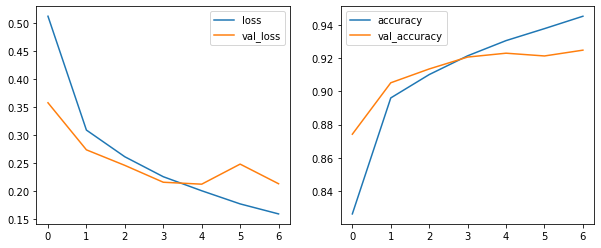

In [121]:
fig, ax = plt.subplots(1, 2, figsize=(10, 4))

history_df = pd.DataFrame(history.history)
history_df[['loss', 'val_loss']].plot(kind='line', ax=ax[0])
history_df[['accuracy', 'val_accuracy']].plot(kind='line', ax=ax[1]);

## Evaluate Model Performance on Test Data

In [122]:
test_images_3ch_scaled = test_images_3ch / 255.
predictions = model.predict(test_images_3ch_scaled)
predictions[:5]

array([[8.0858683e-08, 2.2102162e-08, 4.0208749e-07, 1.5100730e-07,
        2.3231181e-08, 1.0232615e-05, 9.6737892e-08, 3.2935161e-05,
        6.5501467e-08, 9.9995589e-01],
       [2.7050645e-04, 4.7154421e-07, 9.9740195e-01, 6.7716223e-06,
        4.5036795e-04, 8.7788221e-06, 1.8488017e-03, 9.7552322e-07,
        7.1788072e-06, 4.2545880e-06],
       [6.4433317e-13, 1.0000000e+00, 3.6955276e-11, 7.0705547e-10,
        1.7348568e-10, 1.1461806e-10, 2.1015967e-10, 7.6561500e-11,
        2.1835127e-12, 2.8746274e-12],
       [2.1091939e-09, 9.9999928e-01, 4.2920448e-08, 3.0445591e-07,
        1.6110026e-07, 8.2360707e-08, 1.3449203e-07, 3.4065867e-08,
        4.3121871e-09, 4.7462385e-09],
       [3.8659373e-01, 8.4636587e-04, 4.5173857e-02, 7.4913315e-03,
        1.2365985e-02, 1.4424956e-03, 5.3948390e-01, 1.7889136e-03,
        3.1418428e-03, 1.6716000e-03]], dtype=float32)

In [123]:
prediction_labels = np.argmax(predictions, axis=1)
prediction_labels[:5]

array([9, 2, 1, 1, 6])

In [124]:
print(classification_report(test_labels, prediction_labels, target_names=class_names))
pd.DataFrame(confusion_matrix(test_labels, prediction_labels), index=class_names, columns=class_names)

              precision    recall  f1-score   support

 T-shirt/top       0.84      0.91      0.87      1000
     Trouser       1.00      0.98      0.99      1000
    Pullover       0.90      0.86      0.88      1000
       Dress       0.96      0.86      0.91      1000
        Coat       0.83      0.90      0.87      1000
      Sandal       0.98      0.99      0.98      1000
       Shirt       0.78      0.78      0.78      1000
     Sneaker       0.96      0.97      0.97      1000
         Bag       0.99      0.99      0.99      1000
  Ankle boot       0.99      0.96      0.97      1000

    accuracy                           0.92     10000
   macro avg       0.92      0.92      0.92     10000
weighted avg       0.92      0.92      0.92     10000



,T-shirt/top,Trouser,Pullover,Dress,Coat,Sandal,Shirt,Sneaker,Bag,Ankle boot
T-shirt/top,907,0,10,6,3,0,67,0,7,0
Trouser,7,978,1,7,2,0,3,0,2,0
Pullover,14,0,856,7,46,0,77,0,0,0
Dress,40,1,7,863,57,0,30,0,1,1
Coat,3,0,48,3,901,0,45,0,0,0
Sandal,0,0,0,0,0,991,0,7,0,2
Shirt,99,0,31,11,72,0,783,0,4,0
Sneaker,0,0,0,0,0,15,0,975,0,10
Bag,4,0,0,0,1,3,0,0,992,0
Ankle boot,0,0,0,0,0,4,1,34,0,961
